<a href="https://colab.research.google.com/github/sajan-sarker/bone-fracture-classifications/blob/main/bone_fracture_classification_effinet_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ...
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)
os.listdir(path)


Path to dataset files: /kaggle/input/fracture-multi-region-x-ray-data


['README.dataset.txt', 'Bone_Fracture_Binary_Classification']

In [ ]:
path = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"
print(path)

/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification


*****
# Necessary Imports

In [ ]:
import os
import time
import copy
import warnings
import random

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image,ImageFile
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from torchvision import datasets, transforms, models

import seaborn as sns
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True

warnings.filterwarnings('ignore')

In [ ]:
# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(("Using :" + torch.cuda.get_device_name(0)) if device.type == 'cuda' else 'Using: CPU')

Using :Tesla P100-PCIE-16GB


*****
# Process Dataset

In [ ]:
train = os.path.join(path, 'train')
val = os.path.join(path, 'val')
test = os.path.join(path, 'test')

In [ ]:
def get_mean_std(loader):
    """ Calculating mean and std for normalization"""
    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # [B, C, H*W]
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)

# mean, std = get_mean_std(train_loader)
# mean, std

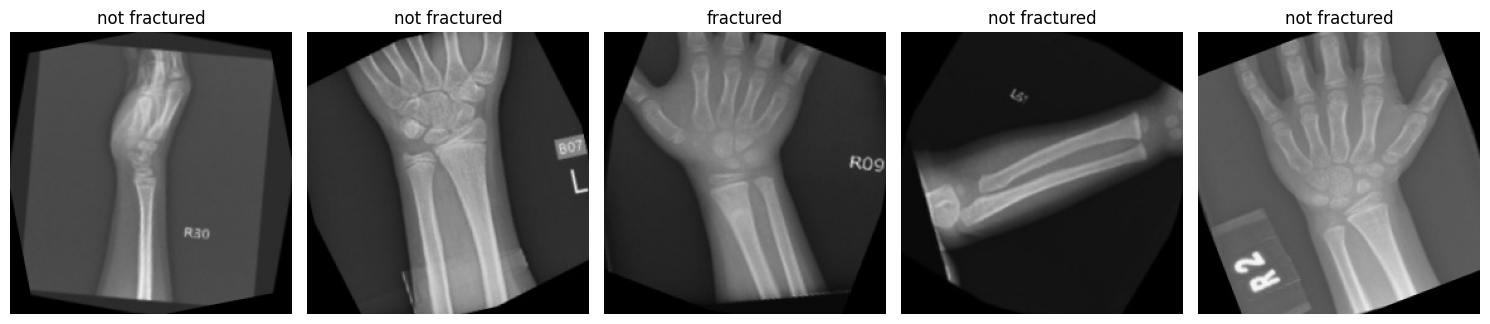

In [ ]:
indices = random.sample(range(len(train_dataset)), 5)
class_names = train_dataset.classes

# Create a 1-row, 5-column subplot
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns

for i, idx in enumerate(indices):
    img, label = train_dataset[idx]

    # Convert tensor to HWC format if needed
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0)  # CxHxW -> HxWxC

    axes[i].imshow(img)
    axes[i].set_title(class_names[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

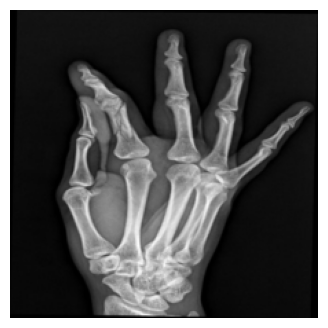

In [ ]:
idx = 0
img, label = train_dataset[idx]
class_names = train_dataset.classes
img = img.permute(1, 2, 0)

plt.figure(figsize=(4, 4))
plt.imshow(img)
# plt.title(class_names[label])
plt.axis('off')
plt.show()

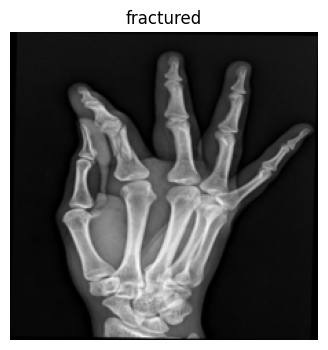

In [ ]:
idx = 0
img, label = train_dataset[idx]
class_names = train_dataset.classes
img = img.permute(1, 2, 0)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(class_names[label])
plt.axis('off')
plt.show()

In [ ]:
mean = [0.2328, 0.2328, 0.2328]
std = [0.2070, 0.2070, 0.2070]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# create dataset clases
train_dataset = datasets.ImageFolder(root=train, transform=transform)
val_dataset = datasets.ImageFolder(root=val, transform=transform)
test_dataset = datasets.ImageFolder(root=test, transform=transform)

# create data loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,pin_memory=True)

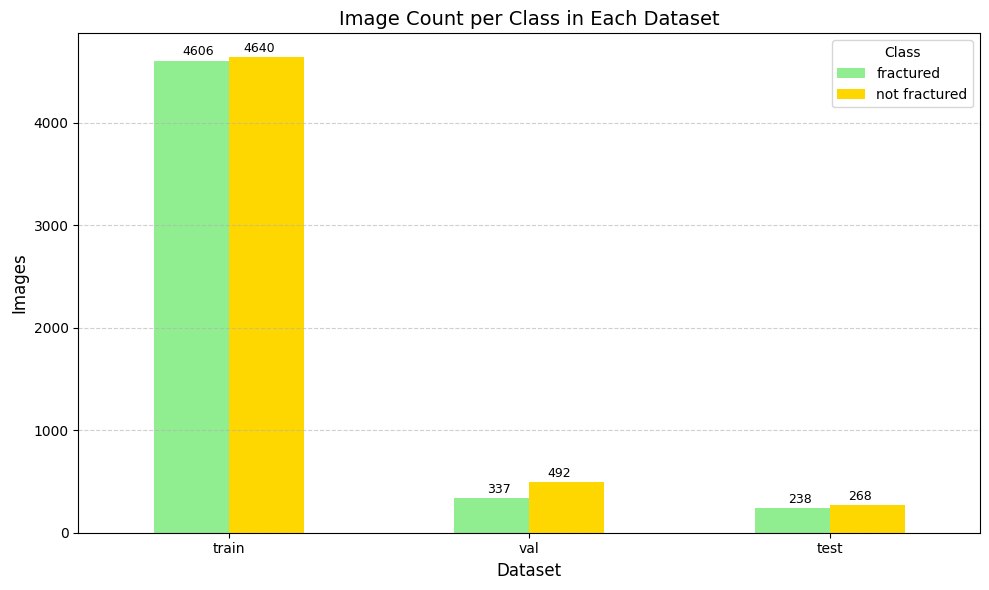

In [ ]:
def data_summary(path):
    summary = []
    categories = ['train', 'val', 'test']
    for split in categories:
        paths = os.path.join(path, split)
        for y in os.listdir(paths):
            class_path = os.path.join(paths, y)
            count = len(os.listdir(class_path))
            summary.append({'split': split,
                            'class' : y,
                            'count' : count
                           })
    return pd.DataFrame(summary)

df = data_summary(path)

df['split'] = pd.Categorical(df['split'], categories=['train', 'val', 'test'], ordered=True)
df = df.sort_values('split')

# Pivot for grouped bar plot
pivot_df = df.pivot(index='split', columns='class', values='count')

colors = ['lightgreen', 'gold']
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)

for i, split in enumerate(pivot_df.index):
    for j, cls in enumerate(pivot_df.columns):
        count = pivot_df.loc[split, cls]
        ax.text(i + j*0.2 - 0.1, count + 25, str(count), ha='center', va='bottom', fontsize=9)

plt.title('Image Count per Class in Each Dataset', fontsize=14)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Images', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

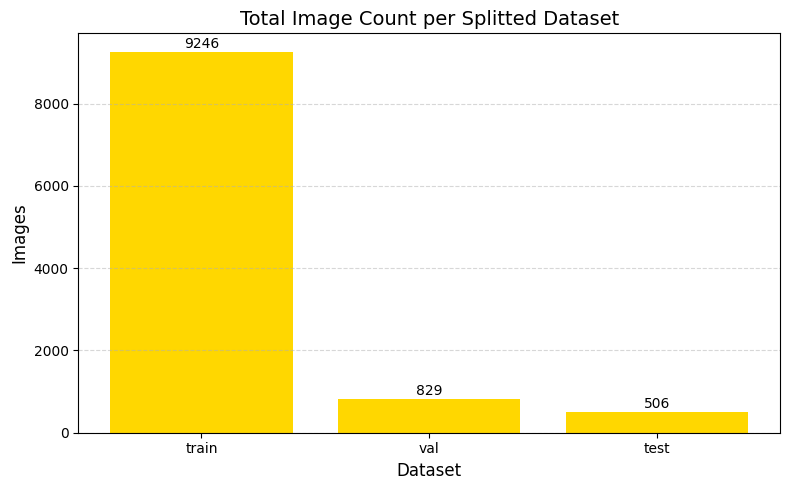

In [ ]:
total_per_split = df.groupby('split')['count'].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(total_per_split.index, total_per_split.values, color='gold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 25, str(yval), ha='center', va='bottom', fontsize=10)

plt.title('Total Image Count per Splitted Dataset', fontsize=14)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Images', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


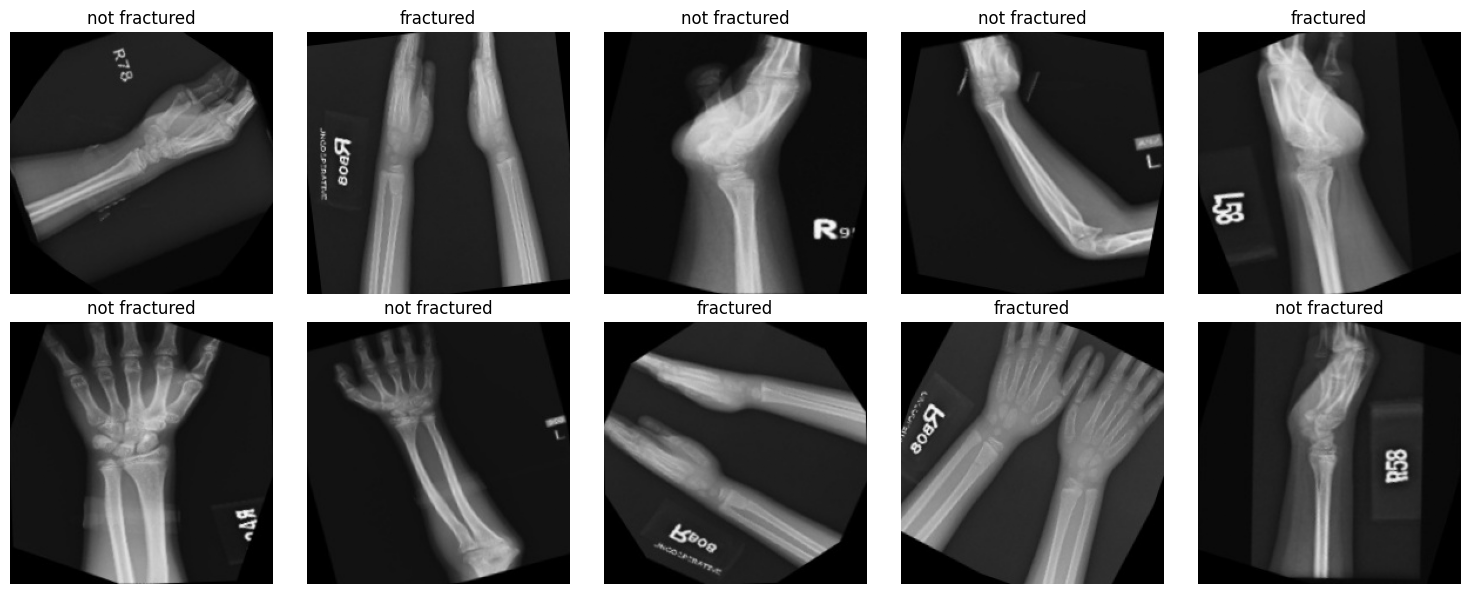

In [ ]:
data_iter = iter(train_dataset)
class_names = train_dataset.classes

indices = random.sample(range(len(train_dataset)), 10)  # 10 random images

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]  # get image and label from dataset
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0)

    axes[i].imshow(img)
    axes[i].set_title(class_names[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

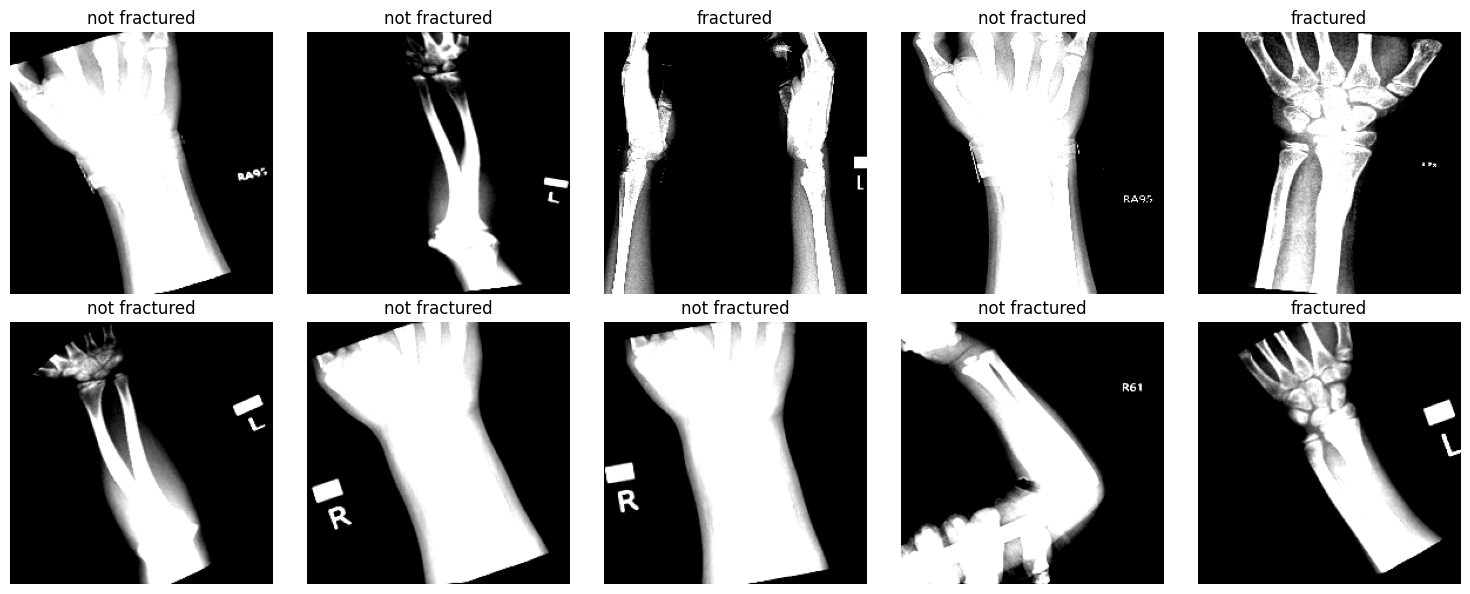

In [ ]:
data_iter = iter(train_dataset)
class_names = train_dataset.classes

indices = random.sample(range(len(train_dataset)), 10)  # 10 random images

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]  # get image and label from dataset
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0)

    axes[i].imshow(img)
    axes[i].set_title(class_names[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

*****
# Pretrained EfficienNet

In [ ]:
eff_model = models.efficientnet_b0(pretrained=True)

num_features = eff_model.classifier[1].in_features
num_classes = len(train_dataset.classes)
eff_model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # dropout to reduce overfitting
    nn.Linear(num_features, num_classes)
)

eff_model = eff_model.to(device)

In [ ]:
summary(eff_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

*****
# Pretrained VGG16

In [ ]:
vgg_model = models.vgg16(pretrained=True)

vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg_model.features.parameters():
    param.required_grad=False

vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
vgg_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=2),
    nn.ReLU(),
)

vgg_model = vgg_model.to(device)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(vgg_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

*****
# Training Loop & Evaluation

In [ ]:
def measure_trainig_time(sec, name):
    """ Measure the model training tiem """
    hours, rem = divmod(sec, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"{name} Training Time: {int(hours)}h {(minutes)}m {int(seconds)}s")

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, best_model, device, patience=5):
    # total training losses & accuracy
    train_losses = []
    train_accuracies = []

    # total validation losses and accuracy
    val_losses = []
    val_accuracies = []

    best_train_acc = 0
    best_val_acc = 0

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_model_path = best_model+".pth"

    # trainig loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # zero gradients for every batcccch
            optimizer.zero_grad()

            # forward pass
            pred = model(batch_X)

            # calculate loss
            loss = criterion(pred, batch_y)

            # backward pass
            loss.backward()

            # update grads
            optimizer.step()

            # calculte total epoch loss
            total_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(pred, 1)

            correct += (predicted == batch_y).sum().item()
            total_samples += batch_y.size(0)

        # calculate training metrics
        train_loss = total_loss / total_samples
        train_acc = correct / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                # forward pass
                pred = model(batch_X)

                # calculate loss
                val_loss += criterion(pred, batch_y).item() * batch_X.size(0)
                _, predicted = torch.max(pred, 1)
                val_correct += (predicted == batch_y).sum().item()
                val_samples += batch_y.size(0)

        # calculate validation metrics
        val_loss = val_loss / val_samples
        val_acc = val_correct / val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # step the scheduler based on validation loss
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = train_loss
            best_train_acc = train_acc
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
            #best_model_wts = copy.deepcopy(best_model_state)
            torch.save(best_model_state, best_model_path)
            # print("Best Model Saved")
        else:
            patience_counter += 1
            if patience_counter >= patience and epoch > 10:
                print(f"Early stopping triggered after {epoch+1} epochs")
                # model.load_state_dict(best_model_state)
                break

    #model.load_state_dict(best_model_wts)

    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }

    return history


In [ ]:
def plot_learning_curves(history, name):
    """ get the model history data as dictionary and plot the learning curve (loss & accuracy curves) """
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_accuracies'], label='Train Accuracies')
    plt.plot(history['val_accuracies'], label='Val Accuracies')
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Epochs")
    plt.ylabel('Losses')
    plt.legend()
    plt.tight_layout()
    plt.show()

def test_evaluation(model, name, test_loader, output_class, device='cuda'):
    """
    Evaluate the deep learning model on test set for CNN models (EfficientNet, VGG16)
    - test set accuracy
    - classification report (precision, recall, f1-score)
    - confusion matrix
    - false positive rate (FPR) per class
    """

    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0
    samples = 0
    correct = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # forward pass
            pred = model(batch_X)

            # calculate loss
            total_loss += criterion(pred, batch_y).item() * batch_X.size(0)
            _, predicted = torch.max(pred, 1)

            correct += (predicted == batch_y).sum().item()
            samples += batch_y.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print("="*100)
    print(" "*40 + "\033[1;34m" + name.upper() + " REPORT" + "\033[0m" + " "*10)
    print("="*100)

    # accuracy
    accuracy = np.mean(all_preds == all_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    # classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=output_class))

    # false positive report
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    fpr = (fp / (fp + tn)).item()
    print(f"False Positive Rate: {fpr:.4f}\n")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=output_class, yticklabels=output_class)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()


*****
# EfficienNet Training Phase

In [ ]:
# training parameters
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(eff_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

start = time.time()
eff_history = train_model(eff_model, train_loader, val_loader, criterion, optimizer, scheduler, 50, 'eff_best_model', device)
measure_trainig_time((time.time()-start), "EfficienNet")

Epoch [1/50] | Train Loss: 0.5768, Val Loss: 0.4455, Train Acc: 0.7138, Val Acc: 0.8589
Epoch [2/50] | Train Loss: 0.3700, Val Loss: 0.2883, Train Acc: 0.8706, Val Acc: 0.8938
Epoch [3/50] | Train Loss: 0.2389, Val Loss: 0.1987, Train Acc: 0.9257, Val Acc: 0.9324
Epoch [4/50] | Train Loss: 0.1485, Val Loss: 0.1507, Train Acc: 0.9605, Val Acc: 0.9505
Epoch [5/50] | Train Loss: 0.0983, Val Loss: 0.1207, Train Acc: 0.9777, Val Acc: 0.9626
Epoch [6/50] | Train Loss: 0.0711, Val Loss: 0.1027, Train Acc: 0.9835, Val Acc: 0.9662
Epoch [7/50] | Train Loss: 0.0532, Val Loss: 0.0922, Train Acc: 0.9875, Val Acc: 0.9662
Epoch [8/50] | Train Loss: 0.0411, Val Loss: 0.0776, Train Acc: 0.9908, Val Acc: 0.9698
Epoch [9/50] | Train Loss: 0.0335, Val Loss: 0.0740, Train Acc: 0.9928, Val Acc: 0.9723
Epoch [10/50] | Train Loss: 0.0273, Val Loss: 0.0706, Train Acc: 0.9944, Val Acc: 0.9686
Epoch [11/50] | Train Loss: 0.0240, Val Loss: 0.0545, Train Acc: 0.9951, Val Acc: 0.9867
Epoch [12/50] | Train Loss: 0.

In [ ]:
eff_model.load_state_dict(torch.load("./eff_best_model.pth"))

<All keys matched successfully>

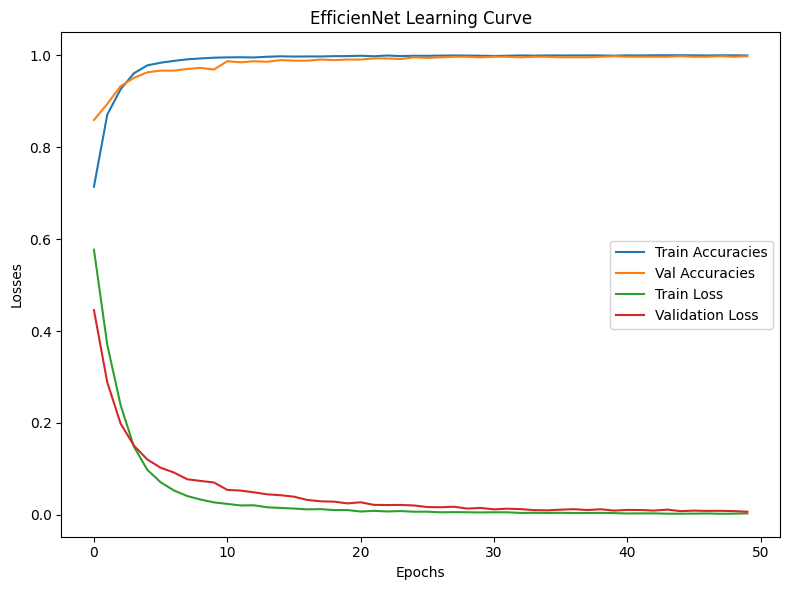

In [ ]:
# evaluation
plot_learning_curves(eff_history, "EfficienNet")

                                        EFFICIENNET REPORT          
Test Accuracy: 0.9921

Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       238
not fractured       0.99      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506

False Positive Rate: 0.0168



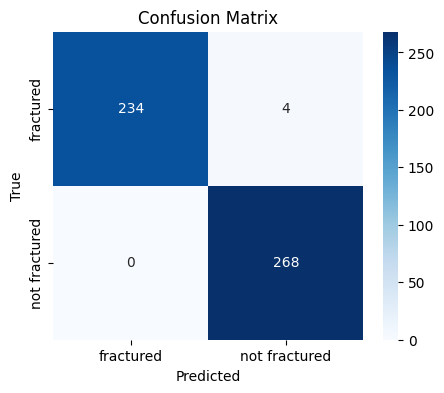

In [ ]:
test_evaluation(eff_model, "EfficienNet", test_loader, class_names, device='cuda')

*****
# VGG Training Phase

In [ ]:
# training parameters
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg_model.classifier.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

start = time.time()
vgg_history = train_model(vgg_model, train_loader, val_loader, criterion, optimizer, scheduler, 50, 'vgg_best_model', device)
measure_trainig_time((time.time()-start), "VGG16")

Epoch [1/50] | Train Loss: 0.6883, Val Loss: 0.6698, Train Acc: 0.5318, Val Acc: 0.7696
Epoch [2/50] | Train Loss: 0.6568, Val Loss: 0.6200, Train Acc: 0.6676, Val Acc: 0.8456
Epoch [3/50] | Train Loss: 0.6130, Val Loss: 0.5734, Train Acc: 0.7681, Val Acc: 0.8685
Epoch [4/50] | Train Loss: 0.5652, Val Loss: 0.5249, Train Acc: 0.8372, Val Acc: 0.8878
Epoch [5/50] | Train Loss: 0.5176, Val Loss: 0.4721, Train Acc: 0.8642, Val Acc: 0.8878
Epoch [6/50] | Train Loss: 0.4682, Val Loss: 0.4237, Train Acc: 0.8858, Val Acc: 0.8951
Epoch [7/50] | Train Loss: 0.4196, Val Loss: 0.3783, Train Acc: 0.8988, Val Acc: 0.9071
Epoch [8/50] | Train Loss: 0.3684, Val Loss: 0.3364, Train Acc: 0.9159, Val Acc: 0.9131
Epoch [9/50] | Train Loss: 0.3252, Val Loss: 0.3005, Train Acc: 0.9235, Val Acc: 0.9216
Epoch [10/50] | Train Loss: 0.2878, Val Loss: 0.2701, Train Acc: 0.9364, Val Acc: 0.9264
Epoch [11/50] | Train Loss: 0.2514, Val Loss: 0.2434, Train Acc: 0.9443, Val Acc: 0.9312
Epoch [12/50] | Train Loss: 0.

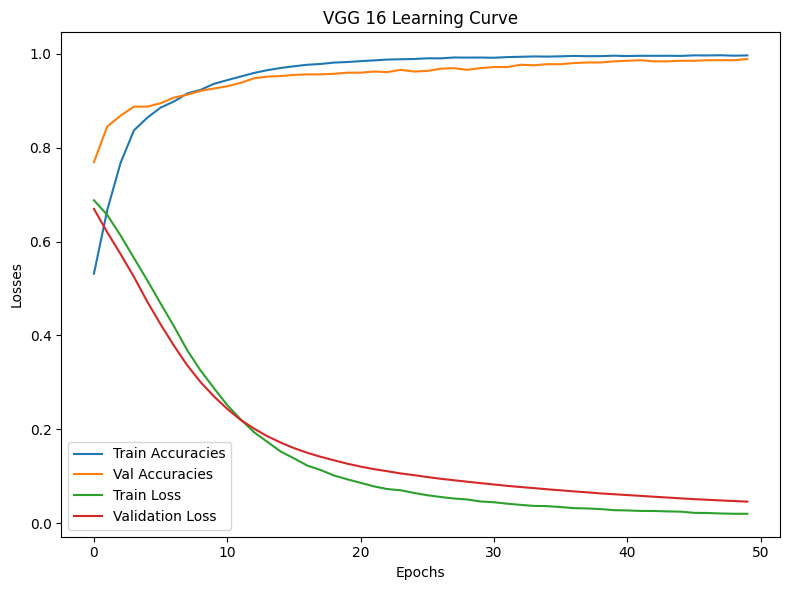

In [ ]:
vgg_model.load_state_dict(torch.load("./vgg_best_model.pth"))

# evaluation
plot_learning_curves(vgg_history, "VGG 16")

                                        VGG 16 REPORT          
Test Accuracy: 0.9842

Classification Report:
               precision    recall  f1-score   support

    fractured       0.98      0.98      0.98       238
not fractured       0.99      0.99      0.99       268

     accuracy                           0.98       506
    macro avg       0.98      0.98      0.98       506
 weighted avg       0.98      0.98      0.98       506

False Positive Rate: 0.0168



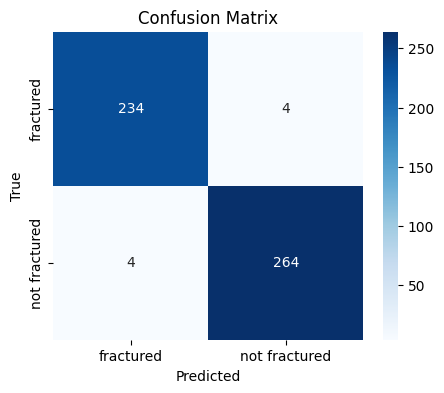

In [ ]:
class_names = train_dataset.classes
test_evaluation(vgg_model, "VGG 16", test_loader, class_names, device='cuda')